In [10]:


import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal
from pathlib import *
from lmfit import models
from tkinter.filedialog import askopenfilename
# ignore used to produce images for blog




In [12]:
refpath=Path("I:\XRD\Thetascan")
file = Path(askopenfilename(initialdir=refpath, title='´Select the folder, with images you want to normalise and select first image'))



'I:\\XRD\\Thetascan\\C02\\HT\\4h_A/xrd-fitting-gaussian.png'

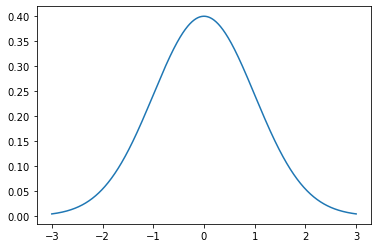

In [16]:
image_dir = file.parent
def plot_to_blog(fig, figure_name):
    filename = os.path.expanduser(f'{image_dir}/{figure_name}')
    fig.savefig(filename)
    return filename

def g(x, A, μ, σ):
    return A / (σ * math.sqrt(2 * math.pi)) * np.exp(-(x-μ)**2 / (2*σ**2))

x = np.linspace(-3, 3, 1000)
fig, ax = plt.subplots()
ax.plot(x, g(x, 1, 0, 1))
plot_to_blog(fig, 'xrd-fitting-gaussian.png')



'I:\\XRD\\Thetascan\\C02\\HT\\4h_A/xrd-fitting-two-gaussian-noise.png'

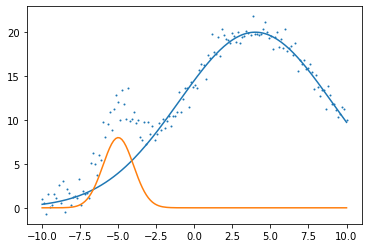

In [19]:


g_0 = [250.0, 4.0, 5.0]
g_1 = [20.0, -5.0, 1.0]
n = 150
x = np.linspace(-10, 10, n)
y = g(x, *g_0) + g(x, *g_1) + np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
ax.plot(x, g(x, *g_0))
ax.plot(x, g(x, *g_1))
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise.png')



steps 70 0.9619960491453179
g_0: amplitude: 20.412 mean: -5.006 sigma: 0.998
g_1: amplitude: 248.173 mean: 4.009 sigma: 4.908


'I:\\XRD\\Thetascan\\C02\\HT\\4h_A/xrd-fitting-two-gaussian-noise-opt.png'

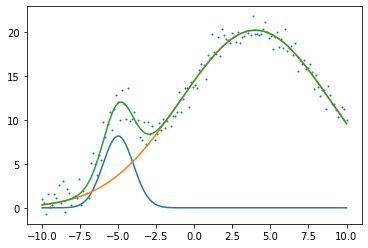

In [28]:


def cost(parameters):
    g_0 = parameters[:3]
    g_1 = parameters[3:6]
    return np.sum(np.power(g(x, *g_0) + g(x, *g_1) - y, 2)) / len(x)

initial_guess = [1, 0, 1, 0.5, 0, 1]
result = optimize.minimize(cost, initial_guess)
print('steps', result.nit, result.fun)
print(f'g_0: amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')
print(f'g_1: amplitude: {result.x[3]:3.3f} mean: {result.x[4]:3.3f} sigma: {result.x[5]:3.3f}')





fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
ax.plot(x, g(x, *result.x[:3]))
ax.plot(x, g(x, *result.x[3:6]))
ax.plot(x, g(x, *result.x[:3]) + g(x, *result.x[3:6]))
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise-opt.png')



'I:\\XRD\\Thetascan\\C02\\HT\\4h_A/xrd-fitting-two-gaussian-noise-lmfit.png'

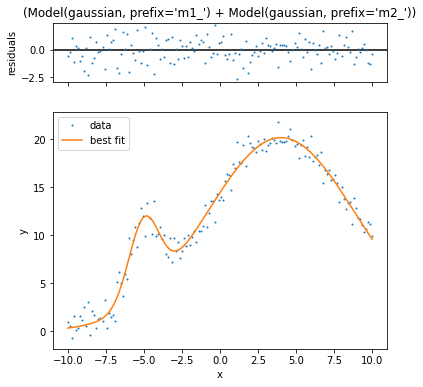

In [33]:
model_1 = models.GaussianModel(prefix='m1_')
model_2 = models.GaussianModel(prefix='m2_')
model = model_1 + model_2

params_1 = model_1.make_params(center=1, sigma=1)
params_2 = model_2.make_params(center=0, sigma=1)
params = params_1.update(params_2)

output = model.fit(y, params, x=x)
output.plot(data_kws={'markersize': 1})
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise-lmfit.png')



In [34]:


def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            # default guess is horrible!! do not use guess()
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params



TypeError: cannot unpack non-iterable Figure object

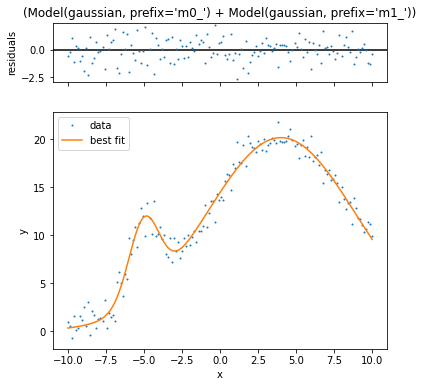

In [35]:


spec = {
    'x': x,
    'y': y,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})
plot_to_blog(fig, 'xrd-fitting-two-gaussian-noise-lmfit-spec.png')



In [116]:


def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths,min_snr=1,noise_perc=10)
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies



In [91]:
df=pd.read_csv(file,header=0,names=['theta','counts'],delimiter='\t')
df

,theta,counts
0,35.01,2054.067
1,35.02,2067.144
2,35.03,2069.668
3,35.04,2101.493
4,35.05,2129.080
...,...,...
8495,119.96,129.118
8496,119.97,131.095
8497,119.98,129.241
8498,119.99,126.621


In [117]:
%matplotlib

spec = {
    'x': df['theta'].values[500:1500],
    'y': df['counts'].values[500:1500],
    'model': [
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
    ]
}

peaks_found = update_spec_from_peaks(spec, [0, 1, 2, 3, 4, 5, 6], peak_widths=(11,25))
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')

plot_to_blog(fig, 'xrd-fitting-xrd-peaks.png')



Using matplotlib backend: Qt5Agg


'I:\\XRD\\Thetascan\\C02\\HT\\4h_A/xrd-fitting-xrd-peaks.png'

In [106]:
signal.cwt(df['counts'].values)

TypeError: cwt() missing 2 required positional arguments: 'wavelet' and 'widths'

In [119]:


model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize':  1})
plot_to_blog(fig, 'xrd-fitting-xrd-total.png')



TypeError: cannot unpack non-iterable Figure object

In [120]:


fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

plot_to_blog(fig, 'xrd-fitting-xrd-components.png')



8


'I:\\XRD\\Thetascan\\C02\\HT\\4h_A/xrd-fitting-xrd-components.png'